In [1]:
import pandas as pd
import numpy as np
import json
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import XLNetTokenizer, XLNetModel,XLNetForSequenceClassification,AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
import seaborn as sns
# from transformers import TFBertForSequenceClassification, BertTokenizer
import torch
import matplotlib.pyplot as plt


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Function to get the total number of lines in the file
def get_total_lines(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        return sum(1 for _ in file)

# Function to load rows where 'stars' feature is 1.0 or 2.0
def load_selected_data_0(filename):
    data = []
    count = 0
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            row = json.loads(line)
            if row.get('stars') in [1.0, 2.0]:  # Check for 1.0 or 2.0 stars
                data.append(row)
                count += 1
                if count == 5000:  # Stop after collecting 5000 rows
                    break
    return data

# Function to load rows where 'stars' feature is 3.0
def load_selected_data_1(filename):
    data = []
    count = 0
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            row = json.loads(line)
            if row.get('stars') == 3.0:
                data.append(row)
                count += 1
                if count == 5000:  # Stop after collecting 5000 rows
                    break
    return data

# Function to load rows where 'stars' feature is 4.0 or 5.0
def load_selected_data_2(filename):
    data = []
    count = 0
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            row = json.loads(line)
            if row.get('stars') in [4.0, 5.0]:  # Check for 4.0 or 5.0 stars
                data.append(row)
                count += 1
                if count == 5000:  # Stop after collecting 5000 rows
                    break
    return data

# File path
file_path = 'yelp_dataset/yelp_academic_dataset_review.json'

# Load the data
yelp_data_0 = pd.DataFrame(load_selected_data_0(file_path))
yelp_data_1 = pd.DataFrame(load_selected_data_1(file_path))
yelp_data_2 = pd.DataFrame(load_selected_data_2(file_path))

In [ ]:
yelp_data_0.head()

In [ ]:
yelp_data_1.head()

In [ ]:
yelp_data_2.head()

In [ ]:
yelp_data = pd.concat([yelp_data_0, yelp_data_1, yelp_data_2])

# Resetting the index of the combined DataFrame
yelp_data.reset_index(drop=True, inplace=True)

# Displaying the first few rows of the combined DataFrame
yelp_data.head()

In [ ]:
# Printing the shape
print("DataFrame Shape:", yelp_data.shape)

In [3]:
duplicates = yelp_data.duplicated()
print("Total duplicate rows:", duplicates.sum())

# Check for missing values
missing_values = yelp_data.isnull().sum()
print('\n',missing_values)

Duplicate entries indices:
Index([], dtype='int64')

Empty entries indices:
Index([], dtype='int64')


In [4]:
# Select the necessary features
yelp_data = yelp_data[['text', 'stars']]

# Map star ratings to sentiment labels (e.g., 0 for 1-2 stars, 1 for 3 stars, 2 for 4-5 stars)
yelp_data['sentiment'] = yelp_data['stars'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

In [5]:
# Split data into train, validation, and test sets
train_data, test_data = train_test_split(yelp_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

In [6]:
# Load pre-trained BERT tokenizer and model in TensorFlow
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Tokenize and preprocess the data
def tokenize_data(data):
    input_ids = []
    attention_masks = []
    labels = []

    for index, row in data.iterrows():
        review = row['text']
        label = row['sentiment']

        encoded_data = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=128,  # You can adjust the maximum sequence length
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_data['input_ids'])
        attention_masks.append(encoded_data['attention_mask'])
        labels.append(label)

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

train_input_ids, train_attention_masks, train_labels = tokenize_data(train_data)
val_input_ids, val_attention_masks, val_labels = tokenize_data(val_data)
test_input_ids, test_attention_masks, test_labels = tokenize_data(test_data)

In [8]:

batch_size = 32

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [10]:
# num_epochs = 3

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0

#     for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
#         batch = tuple(t.to(device) for t in batch)
#         input_ids, attention_mask, labels = batch

#         optimizer.zero_grad()

#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         total_loss += loss.item()

#         loss.backward()
#         optimizer.step()

#     average_loss = total_loss / len(train_dataloader)
#     print(f'Average Loss: {average_loss:.4f}')

Epoch 1: 100%|██████████| 250/250 [3:35:13<00:00, 51.65s/it]  


Average Loss: 0.4321


Epoch 2: 100%|██████████| 250/250 [3:23:50<00:00, 48.92s/it]  


Average Loss: 0.2995


Epoch 3: 100%|██████████| 250/250 [3:03:48<00:00, 44.11s/it]  

Average Loss: 0.2265


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 20

# Early stopping parameters
early_stopping_patience = 3  # Number of epochs to wait after last time validation loss improved.
best_val_loss = float('inf')  # Initialize the best validation loss as infinity.
early_stopping_counter = 0    # Counter for how many epochs without improvement.

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    average_loss = total_loss / len(train_dataloader)
    train_accuracy = correct / total

    train_losses.append(average_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    for batch in tqdm(val_dataloader, desc='Validation'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            if isinstance(outputs, tuple):
                loss = outputs[0]
            elif isinstance(outputs, dict):
                loss = outputs['loss']
            else:
                raise ValueError("Loss not found in model outputs.")
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_average_loss = val_loss / len(val_dataloader)
    val_accuracy = val_correct / val_total

    val_losses.append(val_average_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1} - Train Loss: {average_loss:.4f} - Val Loss: {val_average_loss:.4f} - Train Acc: {train_accuracy:.4f} - Val Acc: {val_accuracy:.4f}')

    # Early stopping check
    if val_average_loss < best_val_loss:
        best_val_loss = val_average_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f'Early stopping triggered. Stopping at epoch {epoch + 1}.')
            break

In [11]:
torch.save(model, 'XLnet.pth')

In [12]:
model = torch.load('XLnet.pth')
model.to(device) 

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [13]:
model.eval()
predictions = []
true_labels = []

for batch in tqdm(val_dataloader, desc='Validation'):
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).tolist()
    predictions.extend(predicted_labels)
    true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions)

print(f'Validation Accuracy: {accuracy:.4f}')
print(report)

Validation: 100%|██████████| 32/32 [05:26<00:00, 10.20s/it]

Validation Accuracy: 0.8780
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       182
           1       0.49      0.55      0.52       107
           2       0.95      0.93      0.94       711

    accuracy                           0.88      1000
   macro avg       0.77      0.78      0.77      1000
weighted avg       0.88      0.88      0.88      1000



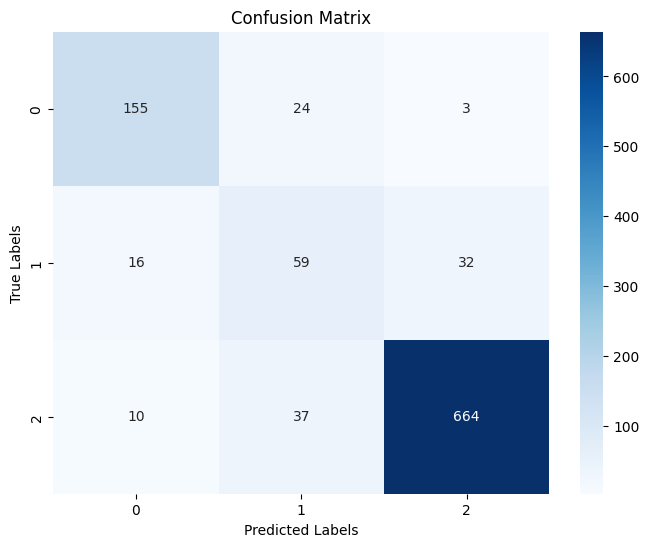

In [14]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

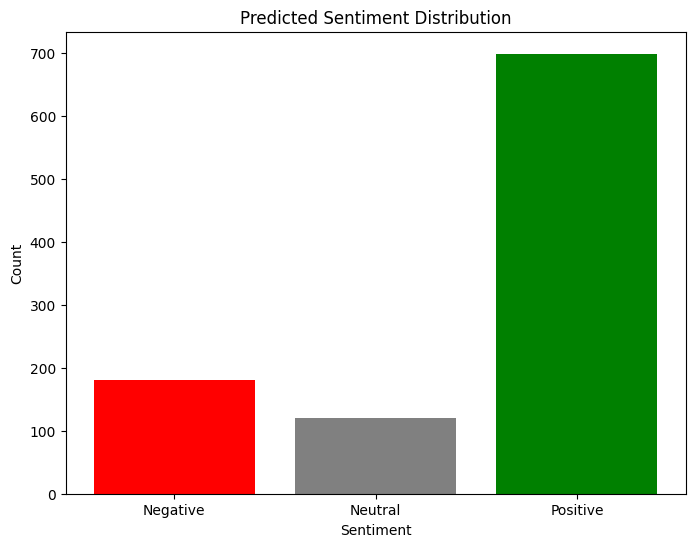

In [15]:
# Count the predicted sentiment labels
predicted_counts = [predictions.count(0), predictions.count(1), predictions.count(2)]

# Define sentiment labels
sentiment_labels = ['Negative', 'Neutral', 'Positive']

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_labels, predicted_counts, color=['red', 'gray', 'green'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Predicted Sentiment Distribution')
plt.show()


In [28]:
def analyze_sentiment(comment):
    # Tokenize and preprocess the comment
    inputs = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=128,  # can adjust the maximum sequence length
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    # Perform inference
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Define sentiment labels
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    print(predicted_label)
    # Get the sentiment label and score
    sentiment_label = sentiment_labels[predicted_label]
    sentiment_score = torch.softmax(logits, dim=1)[0][predicted_label].item()

    return sentiment_label, sentiment_score


In [31]:
comment = "worst place"
sentiment_label, sentiment_score = analyze_sentiment(comment)

print(f"Sentiment: {sentiment_label}")
print(f"Sentiment Score: {sentiment_score:.4f}")

2
Sentiment: Positive
Sentiment Score: 0.4756
